In [15]:
import sys
sys.path.append('../proto/')

import search_pb2
import search_pb2_grpc
import grpc

In [16]:
channel = grpc.insecure_channel('localhost:50051')
stub = search_pb2_grpc.SearchServiceStub(channel)

In [17]:
req = search_pb2.Request(keyword='test')

In [18]:
res = stub.Search(req)

In [19]:
docs = res.docs

In [20]:
docs[0]

id: "B081B7SXZS"
title: "test-title-comixology"

# Retrievalの精度をパラメータを変えて調べる
- Retrievalなのでとりあえずrecallが高いことが保証できればいいとする

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [22]:
train = pd.read_csv('../../data/examples_train.csv')

In [69]:
# 関連度が高いものがどれくらい含まれているかを調べるためにSubstituteまでをrecallを計算する評価対象にする
relevant_df = train[train['esci_label']>=0.1].copy()

## Exp1
- スコア関数は`title bm25 * 1 + description bm25 * 0.1`
- 各クエリで100件ずつ取得し、そのrecall@100の分布を調べる

In [70]:
queries = []
recalls = []
for q, gr in tqdm.tqdm(relevant_df.groupby('query')):
    req = search_pb2.Request(keyword=q)
    res = stub.Search(req)
    res_ids = set(map(lambda x: x.id, res.docs))
    true_ids = set(gr.product_id.unique())
    recall = len(res_ids&true_ids)/len(true_ids)
    recalls.append(recall)
    queries.append(q)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7247/7247 [02:20<00:00, 51.56it/s]


(array([1285.,  466.,  607.,  482.,  514.,  761.,  650.,  583.,  672.,
        1227.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

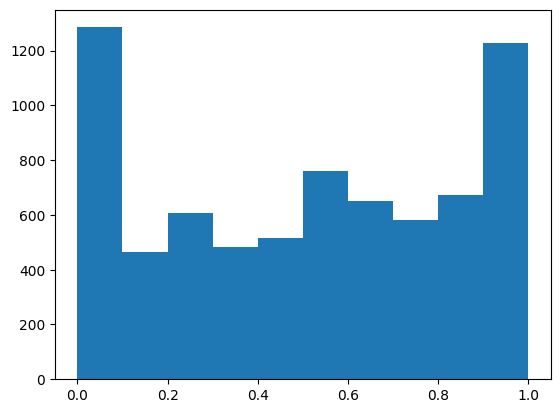

In [71]:
plt.hist(recalls)

In [72]:
pd.Series(recalls).describe()

count    7247.000000
mean        0.505578
std         0.336961
min         0.000000
25%         0.200000
50%         0.521739
75%         0.800000
max         1.000000
dtype: float64

In [73]:
pos_q = queries[np.argmax(recalls)]
neg_q = queries[np.argmin(recalls)]
use_cols = ['query', 'product_title', 'product_description']

In [74]:
relevant_df.loc[train['query']==pos_q, use_cols]

,query,product_title,product_description
99,(知っていることはあまりないけれど)家族です,韓国ドラマ 《知っていることはあまりないけれど家族です》 全話セット DVD版 日本語字幕,韓国ドラマ 《知っていることはあまりないけれど家族です》 全話セット DVD版 日本語字幕です。


In [75]:
relevant_df.loc[train['query']==neg_q, use_cols]

,query,product_title,product_description
56,(マックバースト） mach burst 軽い コンフォート 穴開き スポーツ サドル 痛く...,（選べるカラー） ロードバイク 軽量 メッシュ サドル / 自転車 （並行輸入品） (黒),通気性抜群！ ロードバイク用 軽量スパイダー メッシュ サドル 適度なしなりで疲労感を抑え、...
57,(マックバースト） mach burst 軽い コンフォート 穴開き スポーツ サドル 痛く...,(マックバースト） Mach Burst 軽い コンフォート 穴開き スポーツ サドル 痛く...,この商品は、ややワイドなシルエットにセンターカットアウトを加えたコンフォートスポーツサドルで...
71,(マックバースト） mach burst 軽い コンフォート 穴開き スポーツ サドル 痛く...,(キャット ハンド) Cat Hand 自転車 サドル 穴あき スポーツサドル ロードバイク...,<b>【商品概要】</b><br> <br> 流線型がスタイリッシュなスポーツタイプのサドル...
83,(マックバースト） mach burst 軽い コンフォート 穴開き スポーツ サドル 痛く...,自転車 低反発 サドル 厚手クッション やわらかタイプ ロードバイク マウンテンバイク 通気...,梱包内容：自転車用シート* 1


## Exp2
- スコア関数は`title bm25 * 10 + description bm25 * 0.1`
- 各クエリで100件ずつ取得し、そのrecall@100の分布を調べる

In [76]:
queries = []
recalls = []
for q, gr in tqdm.tqdm(relevant_df.groupby('query')):
    req = search_pb2.Request(keyword=q)
    res = stub.Search(req)
    res_ids = set(map(lambda x: x.id, res.docs))
    true_ids = set(gr.product_id.unique())
    recall = len(res_ids&true_ids)/len(true_ids)
    recalls.append(recall)
    queries.append(q)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7247/7247 [02:13<00:00, 54.16it/s]


(array([1290.,  466.,  594.,  501.,  508.,  755.,  650.,  589.,  681.,
        1213.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

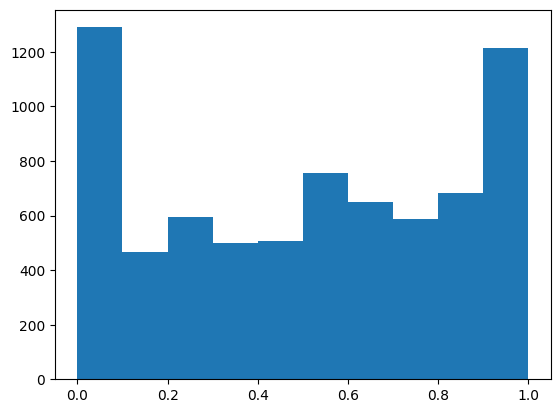

In [77]:
plt.hist(recalls)

In [78]:
pd.Series(recalls).describe()

count    7247.000000
mean        0.504890
std         0.336764
min         0.000000
25%         0.200000
50%         0.516129
75%         0.800000
max         1.000000
dtype: float64

In [79]:
pos_q = queries[np.argmax(recalls)]
neg_q = queries[np.argmin(recalls)]
use_cols = ['query', 'product_title', 'product_description']

In [80]:
relevant_df.loc[train['query']==pos_q, use_cols]

,query,product_title,product_description
99,(知っていることはあまりないけれど)家族です,韓国ドラマ 《知っていることはあまりないけれど家族です》 全話セット DVD版 日本語字幕,韓国ドラマ 《知っていることはあまりないけれど家族です》 全話セット DVD版 日本語字幕です。


In [81]:
relevant_df.loc[train['query']==neg_q, use_cols]

,query,product_title,product_description
56,(マックバースト） mach burst 軽い コンフォート 穴開き スポーツ サドル 痛く...,（選べるカラー） ロードバイク 軽量 メッシュ サドル / 自転車 （並行輸入品） (黒),通気性抜群！ ロードバイク用 軽量スパイダー メッシュ サドル 適度なしなりで疲労感を抑え、...
57,(マックバースト） mach burst 軽い コンフォート 穴開き スポーツ サドル 痛く...,(マックバースト） Mach Burst 軽い コンフォート 穴開き スポーツ サドル 痛く...,この商品は、ややワイドなシルエットにセンターカットアウトを加えたコンフォートスポーツサドルで...
71,(マックバースト） mach burst 軽い コンフォート 穴開き スポーツ サドル 痛く...,(キャット ハンド) Cat Hand 自転車 サドル 穴あき スポーツサドル ロードバイク...,<b>【商品概要】</b><br> <br> 流線型がスタイリッシュなスポーツタイプのサドル...
83,(マックバースト） mach burst 軽い コンフォート 穴開き スポーツ サドル 痛く...,自転車 低反発 サドル 厚手クッション やわらかタイプ ロードバイク マウンテンバイク 通気...,梱包内容：自転車用シート* 1


In [ ]:
# あまり変わらないが少し悪くなった

## Exp3
- スコア関数は`title bm25 * 1 + description bm25 * 0.1`
- 各クエリで200件ずつ取得し、そのrecall@200の分布を調べる

In [83]:
queries = []
recalls = []
for q, gr in tqdm.tqdm(relevant_df.groupby('query')):
    req = search_pb2.Request(keyword=q)
    res = stub.Search(req)
    res_ids = set(map(lambda x: x.id, res.docs))
    true_ids = set(gr.product_id.unique())
    recall = len(res_ids&true_ids)/len(true_ids)
    recalls.append(recall)
    queries.append(q)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7247/7247 [03:23<00:00, 35.69it/s]


(array([1119.,  381.,  501.,  404.,  437.,  718.,  603.,  625.,  860.,
        1599.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

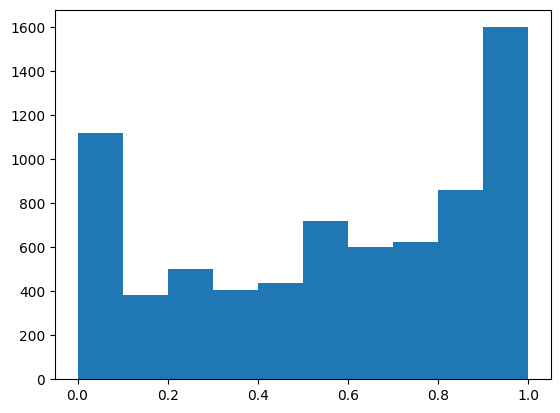

In [84]:
plt.hist(recalls)

In [85]:
pd.Series(recalls).describe()

count    7247.000000
mean        0.560730
std         0.342257
min         0.000000
25%         0.250000
50%         0.617647
75%         0.871381
max         1.000000
dtype: float64

In [86]:
pos_q = queries[np.argmax(recalls)]
neg_q = queries[np.argmin(recalls)]
use_cols = ['query', 'product_title', 'product_description']

In [87]:
relevant_df.loc[train['query']==pos_q, use_cols]

,query,product_title,product_description
99,(知っていることはあまりないけれど)家族です,韓国ドラマ 《知っていることはあまりないけれど家族です》 全話セット DVD版 日本語字幕,韓国ドラマ 《知っていることはあまりないけれど家族です》 全話セット DVD版 日本語字幕です。


In [88]:
relevant_df.loc[train['query']==neg_q, use_cols]

,query,product_title,product_description
56,(マックバースト） mach burst 軽い コンフォート 穴開き スポーツ サドル 痛く...,（選べるカラー） ロードバイク 軽量 メッシュ サドル / 自転車 （並行輸入品） (黒),通気性抜群！ ロードバイク用 軽量スパイダー メッシュ サドル 適度なしなりで疲労感を抑え、...
57,(マックバースト） mach burst 軽い コンフォート 穴開き スポーツ サドル 痛く...,(マックバースト） Mach Burst 軽い コンフォート 穴開き スポーツ サドル 痛く...,この商品は、ややワイドなシルエットにセンターカットアウトを加えたコンフォートスポーツサドルで...
71,(マックバースト） mach burst 軽い コンフォート 穴開き スポーツ サドル 痛く...,(キャット ハンド) Cat Hand 自転車 サドル 穴あき スポーツサドル ロードバイク...,<b>【商品概要】</b><br> <br> 流線型がスタイリッシュなスポーツタイプのサドル...
83,(マックバースト） mach burst 軽い コンフォート 穴開き スポーツ サドル 痛く...,自転車 低反発 サドル 厚手クッション やわらかタイプ ロードバイク マウンテンバイク 通気...,梱包内容：自転車用シート* 1


In [ ]:
# 中央値が10%くらい上がったのでrecall自体は改善しているが平均があまり変わってないことから無理なものは無理という感じか